In [12]:
import os
os.chdir("..\\..\\")

In [13]:
import networkx as nx
import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt

In [141]:
# Start with pct% of population infected
def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    
    for node in G.nodes():
        if node in infected: 
            G.nodes[node].update({'status' : 'infected',
                                  'infection_day': 0, 
                                  'contacts_infected': 0})
        else:
            G.nodes[node].update({'status': 'susceptible', 
                                  'infection_day' : -1, 
                                  'contacts_infected': 0})

def recover_one_step(G, day, recover_time = 12):
    """
    Recover everyone that has been infected recover_time days or more
    """

    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            if day - G.nodes[node]['infection_day'] >= recover_time: 
                G.nodes[node]['status'] = 'recovered'

def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected', 'infection_day': day})
        
    return len(newly_infected)


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and recovered
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result

def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman'):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(1000)
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model):
    G = init_graph(initial_infection, graph_model)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop
    
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, lambda_leak=.05, graph_model = 'relaxed_caveman'):
    """
    Runs the course of the pandemic from the start until
    90% of the population is simultaneously infected or no one is infected
    """
    
    G, data, status, pop = init_parameters(initial_infection, graph_model)

    day = 0
    while status['infected']>(.01*pop) and  (status['recovered']+status['susceptible'])<pop:
        day +=1
        
        recover_one_step(G, day, recover_time)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        status = current_status(G)
        i = status['infected'] / pop
        s = status['susceptible'] / pop
        r = status['recovered'] / pop
        
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True) if node['status'] == 'recovered']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
        data.append([s, i, r, newly_infected, contacts_infected])
    columns = ['susceptible', 'infected', 'recovered', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series


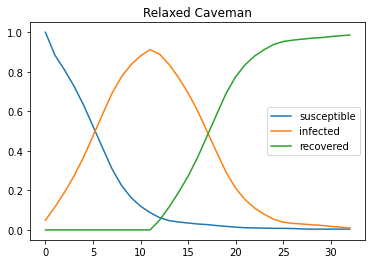

In [144]:
time_series = simulate_pandemic(p_r = 0.4, lambda_leak=.01)

plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['recovered'], label = 'recovered')
plt.legend()
plt.title('Relaxed Caveman')
plt.show()

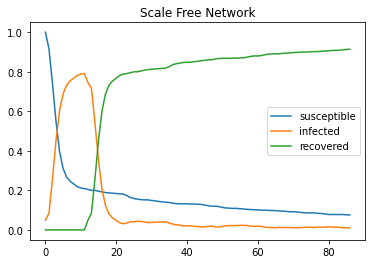

In [145]:
time_series = simulate_pandemic(graph_model='scale_free', p_r = 0.4, lambda_leak=.01)

plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['recovered'], label = 'recovered')
plt.legend()
plt.title('Scale Free Network')
plt.show()